# Project Summary

The main objective of this project is to develop a model to predict the runway length needed for a certain type of millitary aircraft based on public millitary database. Many factors could influence the required runway length including the series, type, category, service country, weight, commission year and other design parameters. This model trys to provide a best match through data analysis thus could predict the runway length code for some newly-developed aircraft. Since it is a duty for the intelligence agencies of every country (governmental, millitary, public, etc.) to monitor the millitary growth of potential enemies, this estimation could help national security to gain first-contact information about the upgrading of equipments. 

## Dataset  Description

The dataset used in this model is the extracted SQLite database of a wargame named "Command: Modern Air/Naval Operations". CMANO is a highly professional modern warfare simulator, which has been introduced into the U.S Navy for training purpose. The software is commercial while its database describing the properties of millitary units is public and modification-permitted, including aircrafts, surface ships, submarines, missiles and other weapons. 

In [1]:
import numpy as np
import pandas as pd

In [2]:
from pylab import *
import matplotlib
import matplotlib.pyplot as plt

In [3]:
import sqlite3

con = sqlite3.connect('DB3K_444.db3')
df_aircraft_basic = pd.read_sql_query("SELECT * from DataAircraft", con)
df_aircraft_basic.head()

,ID,Category,Type,Name,Comments,OperatorCountry,OperatorService,YearCommissioned,YearDecommissioned,Length,...,Crew,Agility,ClimbRate,OODADetectionCycle,OODATargetingCycle,OODAEvasiveCycle,TotalEndurance,PhysicalSizeCode,RunwayLengthCode,Hypothetical
0,3,2003,6001,SH-60B Seahawk,-,2101,2002,1991,0,15.2,...,3,1.0,5.7,15,15,2,0,2002,2001,0
1,4,2003,6001,Ka-27PL Helix A,-,2088,2204,1982,1991,11.3,...,3,1.0,8.6,15,15,2,0,2001,2001,0
2,5,2001,6002,Il-38 May,-,2088,2204,1982,1991,39.6,...,8,1.0,3.9,15,20,2,0,2004,2004,0
3,6,2001,2002,F-15E Strike Eagle,-,2101,2001,1995,0,19.3,...,2,4.5,99.9,15,15,2,0,2003,2004,0
4,7,2003,6001,SH-3H Sea King,-,2101,2002,1984,0,16.5,...,4,1.0,7.7,15,20,2,0,2002,2001,0


The above list shows the basic properties of aircraft, each type of aircraft has a unique ID, while the following properties are represented by code: 
* category
* type
* operator country
* physical size
* runway length (the target to predict)

Some other parameters we need to analyze in this frame are 
* name
* commission year
* climb rate
* weight: empty, max and payload

The name could be identical for the series of an aircraft, yet could vary with the design, commissioned country and performance.

In [4]:
df_runwaylen = pd.read_sql_query("SELECT * from EnumAircraftRunwayLength", con)
df_runwaylen.head(10)

,ID,Description
0,1001,None
1,2001,0m (VTOL) TOD/LAD
2,2002,1-450m TOD/LAD
3,2003,451-900m TOD/LAD
4,2004,901-1400m TOD/LAD
5,2005,1401-2000m TOD/LAD
6,2006,2001m-2600m TOD/LAD
7,2007,2601-3200m TOD/LAD


In [5]:
df_category = pd.read_sql_query("SELECT * from EnumAircraftCategory", con)
df_category.head(10)

,ID,Description
0,1001,None
1,2001,Fixed Wing
2,2002,"Fixed Wing, Carrier Capable"
3,2003,Helicopter
4,2004,Tiltrotor
5,2006,Airship
6,2007,Seaplane
7,2008,Amphibian


In [6]:
df_type = pd.read_sql_query("SELECT * from EnumAircraftType", con)
df_type.head(10)

,ID,Description
0,1001,None
1,2001,Fighter
2,2002,Multirole (Fighter/Attack)
3,2101,Anti-Satellite Interceptor (ASAT)
4,2102,Airborne Laser Platform
5,3001,Attack
6,3002,Wild Weasel
7,3101,Bomber
8,3401,Battlefield Air Interdiction (BAI/CAS)
9,4001,Electronic Warfare


In [7]:
df_country = pd.read_sql_query("SELECT * from EnumOperatorCountry", con)
df_country.head(10)

,ID,Description,YearStart,YearEnd
0,1001,None,NaN,NaN
1,1002,Unknown,NaN,NaN
2,1003,Generic,NaN,NaN
3,1101,Civilian,NaN,NaN
4,1102,Commercial,NaN,NaN
5,1201,Pirates,NaN,NaN
6,1202,Rebels,NaN,NaN
7,1203,Terrorists,NaN,NaN
8,2001,Abu Dhabi,NaN,NaN
9,2002,Albania,NaN,NaN


Some of the operator countries are invalid for millitary purpose and should be wrangled.

In [8]:
df_size = pd.read_sql_query("SELECT * from EnumAircraftPhysicalSize", con)
df_size.head(10)

,ID,Description
0,1001,None
1,2001,Small Aircraft (Length 0-12m)
2,2002,Medium Aircraft (Length 12.1-18m)
3,2003,Large Aircraft (Length 18.1-26m)
4,2004,Very Large Aircraft (Length 26.1-75m)


Besides, the propulsors could also affect the rate thus require investigation. It is represented by the code instead of name.

In [9]:
df_propulsion = pd.read_sql_query("SELECT * from DataAircraftPropulsion", con)
df_propulsionlist = pd.read_sql_query("SELECT * from DataPropulsion", con)
df_propulsionlist.head(5)

,ID,Name,Type,Comments,Hypothetical,NumberOfEngines,ThrustPerEngineMilitary,ThrustPerEngineAfterburner,SFCMilitary,SFCAfterburner
0,3,2x 58A Diesels,3001,-,0,0.0,0.0,0.0,0.0,0.0
1,4,8x A2W Nuclear Reactors,3004,-,0,0.0,0.0,0.0,0.0,0.0
2,5,1x Orpheus BOr.2 Mk701-01,2001,-,0,1.0,2133.0,0.0,1.1,0.0
3,6,2x TV-9 Boilers & Steam Turbines,3002,-,0,0.0,0.0,0.0,0.0,0.0
4,7,Torpedo Engine,5002,-,0,0.0,0.0,0.0,0.0,0.0


## Data Visualization

### 1. Total Percentage of Required Runway Length

In [10]:
Runway = df_aircraft_basic.groupby(['RunwayLengthCode']).size()
Runway.index = df_runwaylen['Description'][1:]

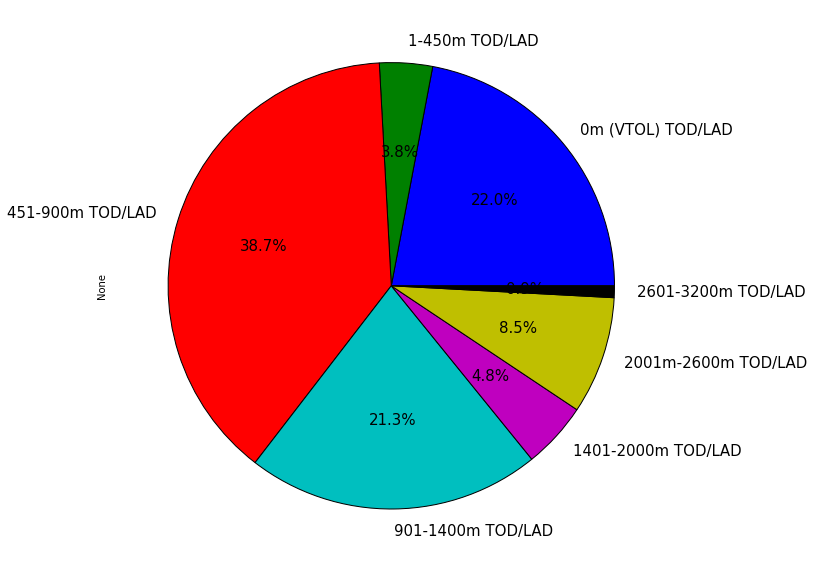

In [11]:
%matplotlib inline
plt.figure()
Runway.plot.pie(fontsize=15,figsize=(10, 10),autopct='%1.1f%%')

### 2. Fractions of Various Properties
#### 2.1 Category

In [12]:
Cat = df_aircraft_basic.groupby(['Category','RunwayLengthCode']).size()
Cat.index = Cat.index.set_levels([df_category['Description'][1:].tolist(),df_runwaylen['Description'][1:].tolist()])

In [13]:
Cat = Cat.unstack(level=1)
Cat[Cat.isnull()]=0
Cat

RunwayLengthCode,0m (VTOL) TOD/LAD,1-450m TOD/LAD,451-900m TOD/LAD,901-1400m TOD/LAD,1401-2000m TOD/LAD,2001m-2600m TOD/LAD,2601-3200m TOD/LAD
Category,,,,,,,
Fixed Wing,41.0,171.0,1622.0,715.0,211.0,380.0,38.0
"Fixed Wing, Carrier Capable",53.0,0.0,105.0,228.0,2.0,0.0,0.0
Helicopter,869.0,0.0,0.0,0.0,0.0,0.0,0.0
Tiltrotor,10.0,0.0,0.0,0.0,0.0,0.0,0.0
Airship,9.0,0.0,0.0,0.0,0.0,0.0,0.0
Seaplane,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Amphibian,1.0,0.0,0.0,7.0,0.0,0.0,0.0


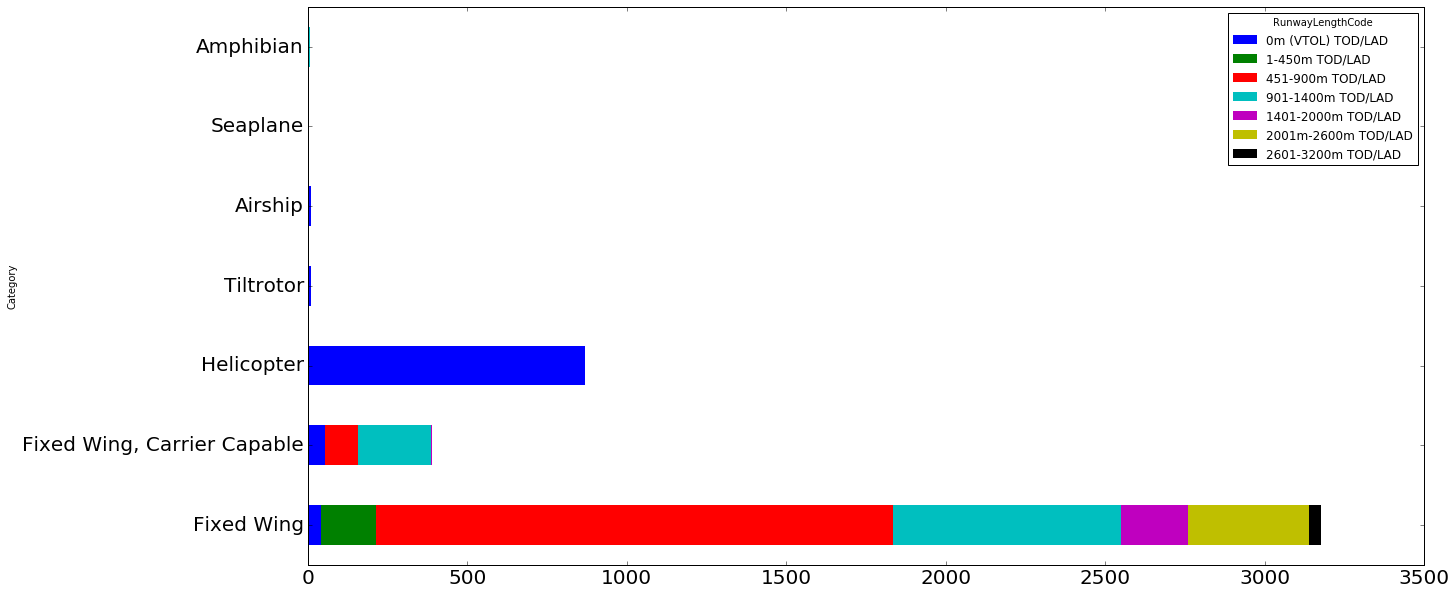

In [14]:
plt.figure()
Cat.plot.barh(fontsize=20,figsize=(20, 10),stacked=True,edgecolor='None')

It can be observed that all helicopters,tiltrotors and airships are VTOL. The majority of fixed wing aircraft require 451-900m TOD/LAD, while many carrier capable aircrafts have fraction of 901-1400m TOD/LAD.

#### 2.2 Type

In [15]:
typ = df_aircraft_basic.groupby(['Type','RunwayLengthCode']).size()
typ.index = typ.index.set_levels([df_type['Description'][1:].tolist(),df_runwaylen['Description'][1:].tolist()])

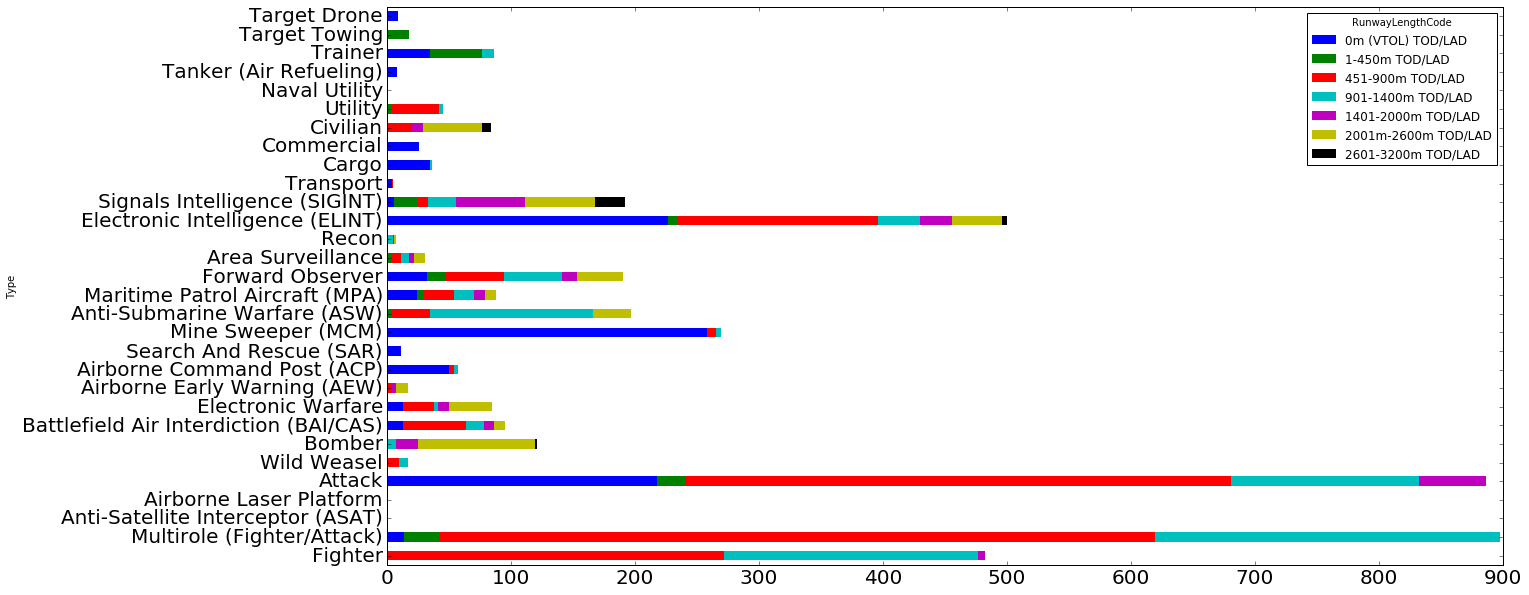

In [16]:
typ = typ.unstack(level=1)
typ[typ.isnull()]=0
plt.figure()
typ.plot.barh(fontsize=20,figsize=(20, 10),stacked=True,edgecolor='None')

It is obvious that the fractions of required runway length varies with the mission of aircraft. While combat related (e.g, AAW, ASuW and ASW) aircrafts tend to have shorter runway length, the supporting aircrafts, especially marine surveiliance and air warning aircrafts require longer runway.

#### 2.3 Physical Size 

In [17]:
siz = df_aircraft_basic.groupby(['PhysicalSizeCode','RunwayLengthCode']).size()
siz.index = siz.index.set_levels([df_size['Description'][1:].tolist(),df_runwaylen['Description'][1:].tolist()])

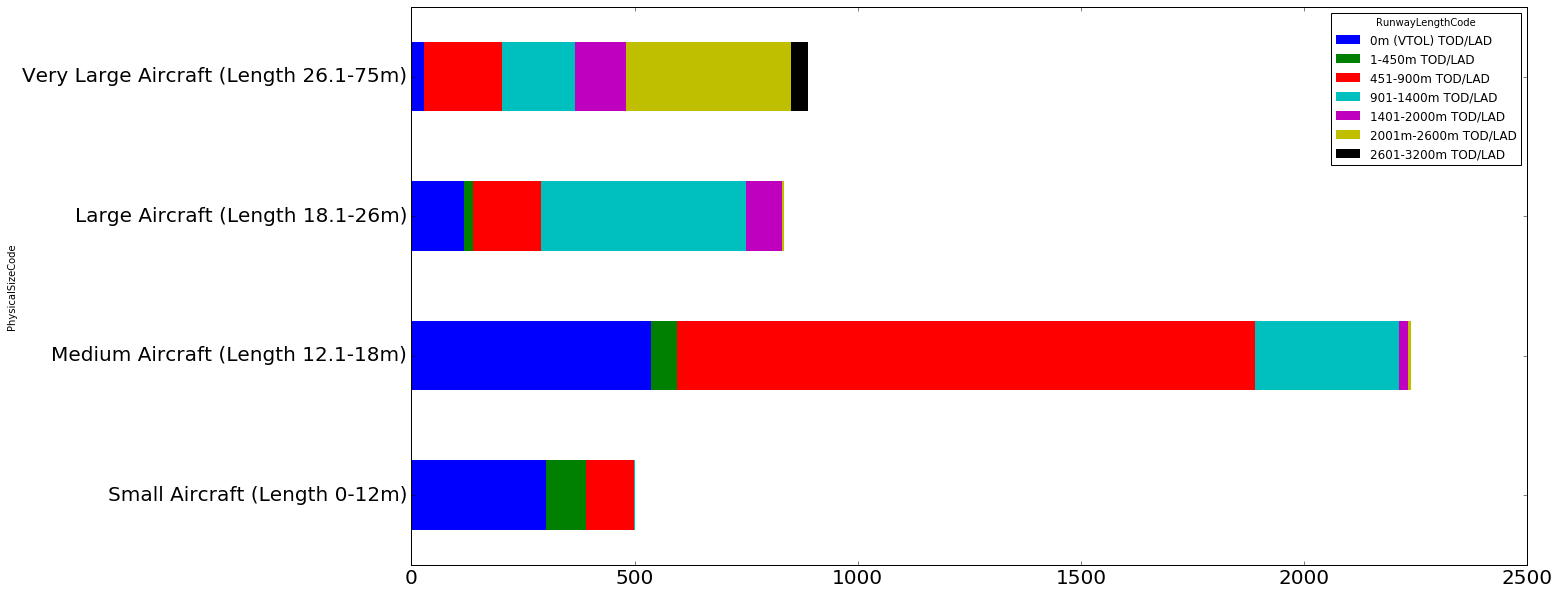

In [18]:
siz = siz.unstack(level=1)
siz[siz.isnull()]=0
plt.figure()
siz.plot.barh(fontsize=20,figsize=(20, 10),stacked=True,edgecolor='None')

#### 2.4 Countries
The strategy for national security and equipment could have significant influence on the runway length. Even within the same series of aircraft, the runway length required for different countries varies. For example, the supporting AEW and MPA aircrafts of USSR usually require longer runway length than the USA, while the required runway lengths of F-15 fighters are different between Japan (F-15J) and Singapore (F-15E). Since there are many countries, the results will not be visualized here.

### 3. Distribution Plots

#### 3.1 Max Weight (For each runway length code)

In [19]:
weight = df_aircraft_basic.set_index(['RunwayLengthCode']).sort_index()

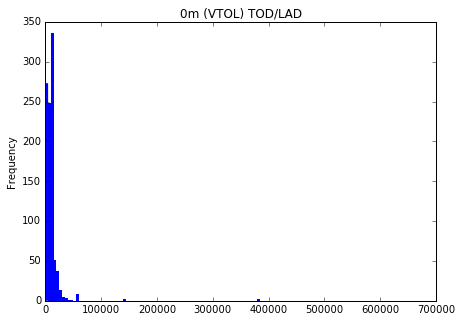

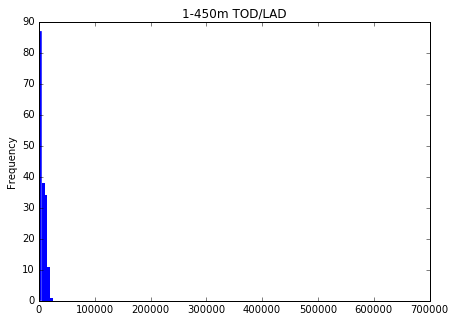

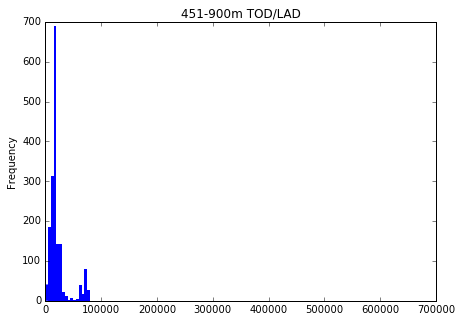

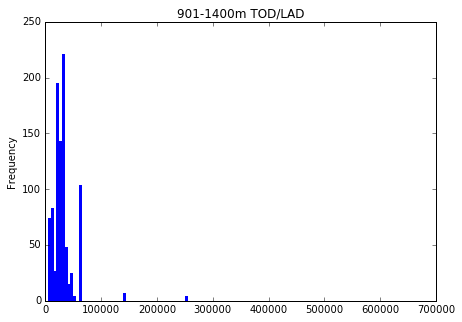

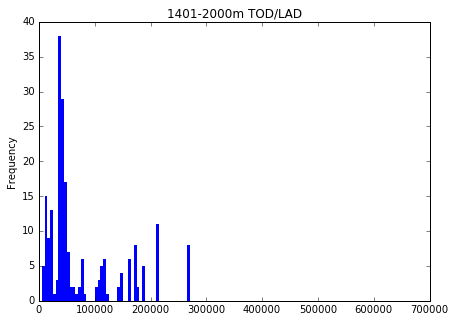

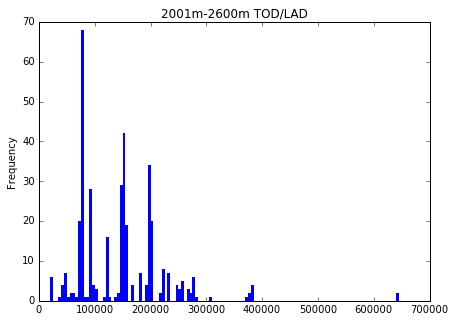

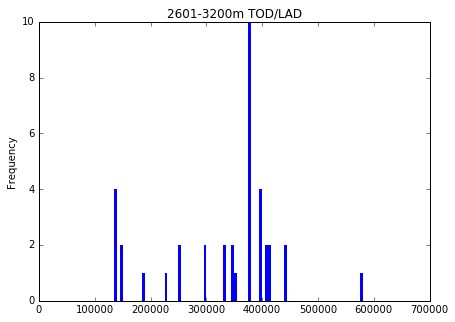

In [76]:
n=1
cat = range(0, 650000, 5000)
for i in df_runwaylen['ID'][1:]:
    ww=weight.loc[i]['WeightMax']
    plt.figure()
    ww.plot.hist(stacked=False,edgecolor='None',figsize=(7, 5),bins = cat)
    plt.title(df_runwaylen['Description'][n])
    n=n+1

#### 3.2 Climb Rate

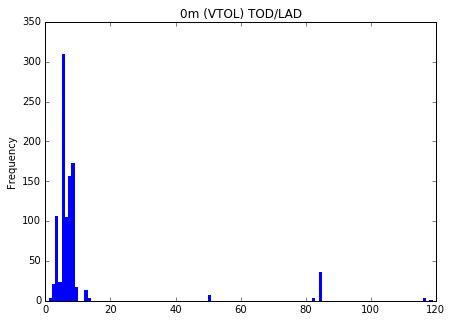

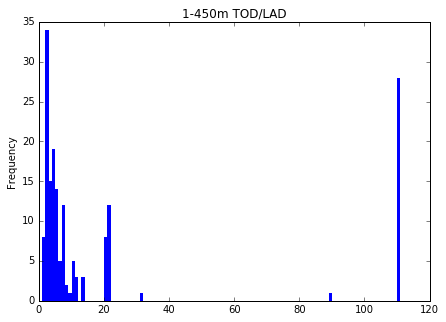

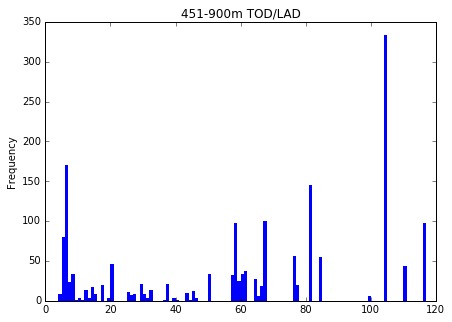

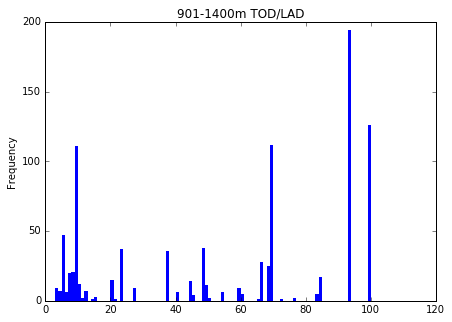

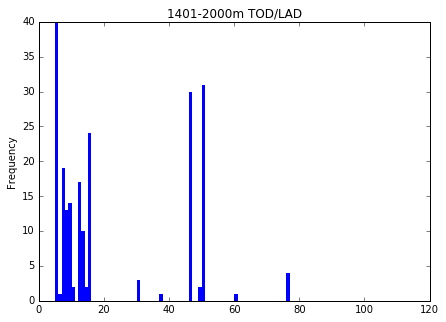

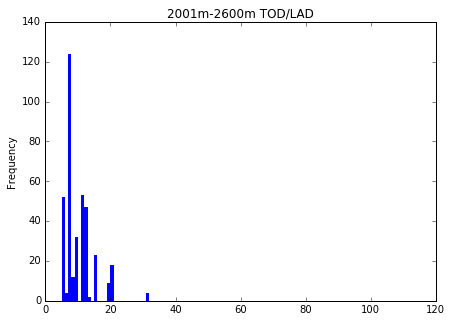

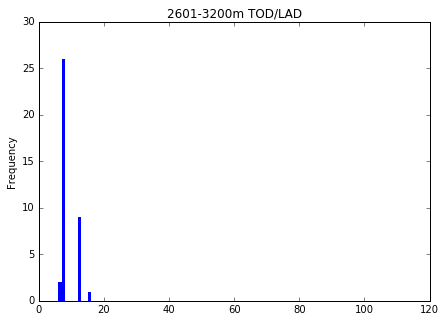

In [77]:
crate = df_aircraft_basic.set_index(['RunwayLengthCode']).sort_index()
cat = range(0, 120, 1)
n=1
for i in df_runwaylen['ID'][1:]:
    plt.figure()
    cc =crate.loc[i]['ClimbRate'] 
    cc.plot.hist(stacked=True,edgecolor='None',figsize=(7,5),bins = cat)
    plt.title(df_runwaylen['Description'][n])
    n=n+1

### 4. Runway Length and Commission Year 

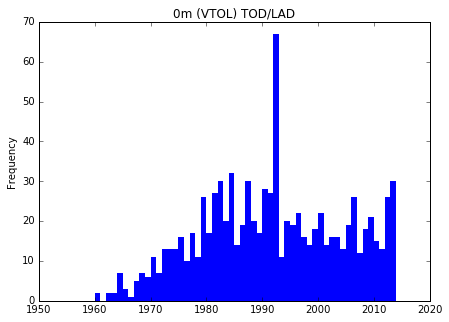

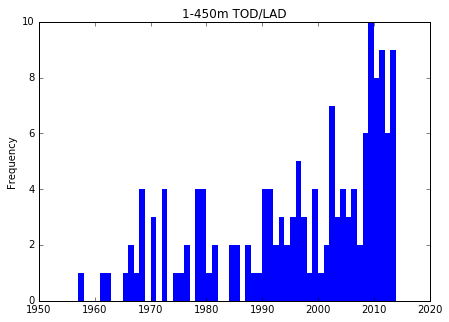

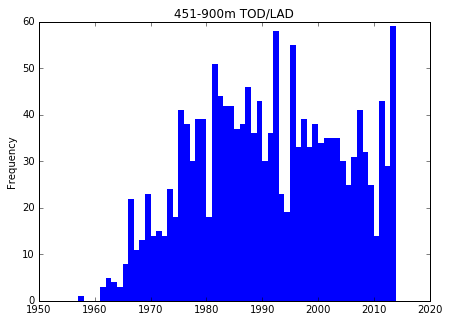

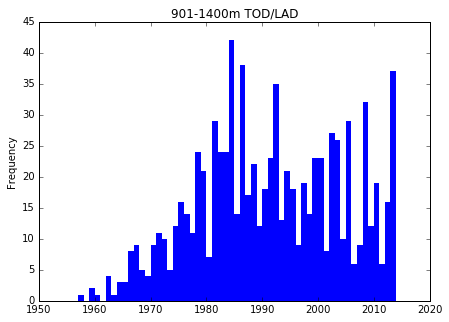

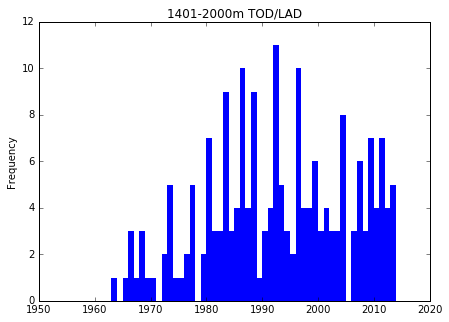

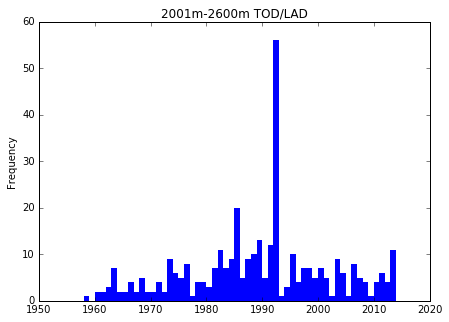

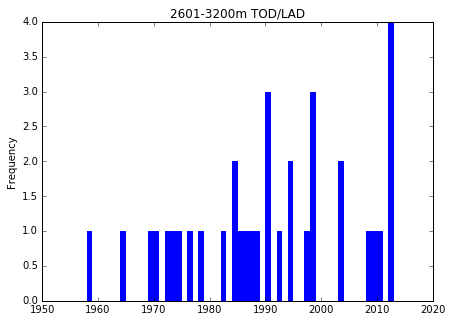

In [74]:
Time = df_aircraft_basic.set_index(['RunwayLengthCode']).sort_index()
cat = range(1955, 2015, 1)
n=1
for i in df_runwaylen['ID'][1:]:
    plt.figure() 
    cc =crate.loc[i]['YearCommissioned']
    cc.plot.hist(stacked=True,edgecolor='None',figsize=(7, 5), bins = cat)
    plt.title(df_runwaylen['Description'][n])
    n=n+1

## Summary
The next step is to apply algorithm for runway decision of a new aircraft. We did not analyze the name text of aircrafts, which should crucial but difficult since the series (e.g., F/A-18 series has many branches like F/A-18C and F/A-18F). Also, the power of propulsion should also be taken into consideration. These will be implemented in the next step.